In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/x-ray-lung-diseases-images-9-classes


In [ ]:
def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        train_val, test = train_test_split(images, test_size=1 - (train_ratio + val_ratio), random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in split_data:
                shutil.copy(os.path.join(class_path, img), os.path.join(split_class_dir, img))

output_path = '/kaggle/working/xray_split'
split_dataset(path, output_path)


In [ ]:
IMG_SIZE = 380
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15,
                                   width_shift_range=0.1, height_shift_range=0.1,
                                   zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(os.path.join(output_path, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical', color_mode='rgb', batch_size=BATCH_SIZE)
val_gen = val_datagen.flow_from_directory(os.path.join(output_path, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical', color_mode='rgb', batch_size=BATCH_SIZE)
test_gen = test_datagen.flow_from_directory(os.path.join(output_path, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical', color_mode='rgb', batch_size=BATCH_SIZE, shuffle=False)


Found 4712 images belonging to 9 classes.
Found 1014 images belonging to 9 classes.
Found 1017 images belonging to 9 classes.


In [ ]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("efficientnet_lung_model.h5", save_best_only=True, monitor='val_accuracy')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[checkpoint, early_stop])


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.5058 - loss: 1.4797

295/295 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.5063 - loss: 1.4782 - val_accuracy: 0.1006 - val_loss: 2.4620
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9146 - loss: 0.2980

295/295 ━━━━━━━━━━━━━━━━━━━━ 259s 736ms/step - accuracy: 0.9147 - loss: 0.2979 - val_accuracy: 0.1262 - val_loss: 2.6120
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9589 - loss: 0.1499

295/295 ━━━━━━━━━━━━━━━━━━━━ 217s 735ms/step - accuracy: 0.9589 - loss: 0.1499 - val_accuracy: 0.1292 - val_loss: 2.4442
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9705 - loss: 0.0975

295/295 ━━━━━━━━━━━━━━━━━━━━ 217s 735ms/step - accuracy: 0.9705 - loss: 0.0975 - val_accuracy: 0.1893 - val_loss: 2.5827
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9809 - loss: 0.0668

295/295 ━━━━━━━━━━━━━━━━━━━━ 219s 741ms/step - accuracy: 0.9809 - loss: 0.0668 - val_accuracy: 0.2475 - val_loss: 3.3004
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 217s 733ms/step - accuracy: 0.9847 - loss: 0.0502 - val_accuracy: 0.0996 - val_loss: 2.4716
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 220s 744ms/step - accuracy: 0.9865 - loss: 0.0418 - val_accuracy: 0.1933 - val_loss: 3.0592
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 261s 740ms/step - accuracy: 0.9891 - loss: 0.0361 - val_accuracy: 0.2002 - val_loss: 3.8725


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='top_conv'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(class_channel, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(img, axis=0) / 255.0
    heatmap = make_gradcam_heatmap(img_array, model)
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = heatmap * 0.4 + img
    plt.imshow(cv2.cvtColor(superimposed.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 380, 380, 3))
  warnings.warn(msg)


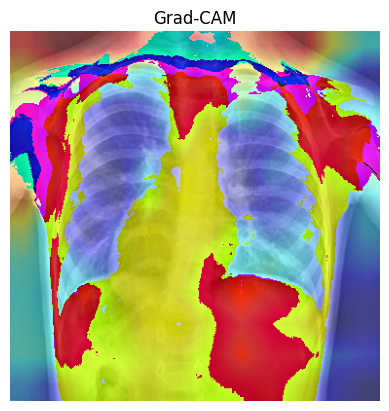

In [ ]:
# Example usage
sample_img_path = test_gen.filepaths[0]
display_gradcam(sample_img_path)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=41df3cb5e3eb080d916fd0553e473729732720f91aafc8940b5d200364e70f0a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

lime_explainer = lime_image.LimeImageExplainer()

def explain_lime(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img_array = np.expand_dims(img, axis=0)
    def predict_fn(x): return model.predict(x)
    explanation = lime_explainer.explain_instance(img.astype('double'), predict_fn, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title("LIME Explanation")
    plt.axis('off')
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

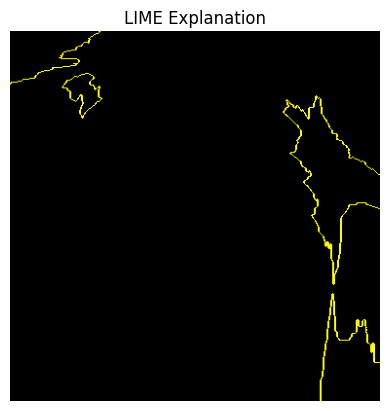

In [ ]:
# Example usage
explain_lime(sample_img_path)

In [ ]:
X_surrogate = []
y_pred = []

for _ in range(5):
    x_batch, _ = next(test_gen)
    preds = model.predict(x_batch)
    X_surrogate.extend(x_batch.reshape(len(x_batch), -1))
    y_pred.extend(np.argmax(preds, axis=1))

surrogate_model = DecisionTreeClassifier(max_depth=5)
surrogate_model.fit(X_surrogate, y_pred)

print("Surrogate model accuracy (approximation):", accuracy_score(y_pred, surrogate_model.predict(X_surrogate)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Surrogate model accuracy (approximation): 1.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Extract features from the pre-trained model (EfficientNetB4)
def extract_features(generator, model):
    features = []
    labels = []
    for data, label in generator:
        # Get the features from the global average pooling layer
        features_batch = model.predict(data)
        features.append(features_batch)
        labels.append(label)

        # Break after going through one batch to avoid memory issues (or adjust as needed)
        break

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features for the training and test sets
train_features, train_labels = extract_features(train_gen, model)
test_features, test_labels = extract_features(test_gen, model)

# Flatten the features for the decision tree model (optional step depending on the surrogate model)
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Train a decision tree classifier as a surrogate model
surrogate_model = DecisionTreeClassifier(max_depth=5)
surrogate_model.fit(train_features_flat, np.argmax(train_labels, axis=1))  # Use argmax for multi-class

# Evaluate the surrogate model
train_preds = surrogate_model.predict(train_features_flat)
test_preds = surrogate_model.predict(test_features_flat)

train_accuracy = accuracy_score(np.argmax(train_labels, axis=1), train_preds)
test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_preds)

print("Surrogate Model Accuracy on Train Data:", train_accuracy)
print("Surrogate Model Accuracy on Test Data:", test_accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Surrogate Model Accuracy on Train Data: 1.0
Surrogate Model Accuracy on Test Data: 0.3125


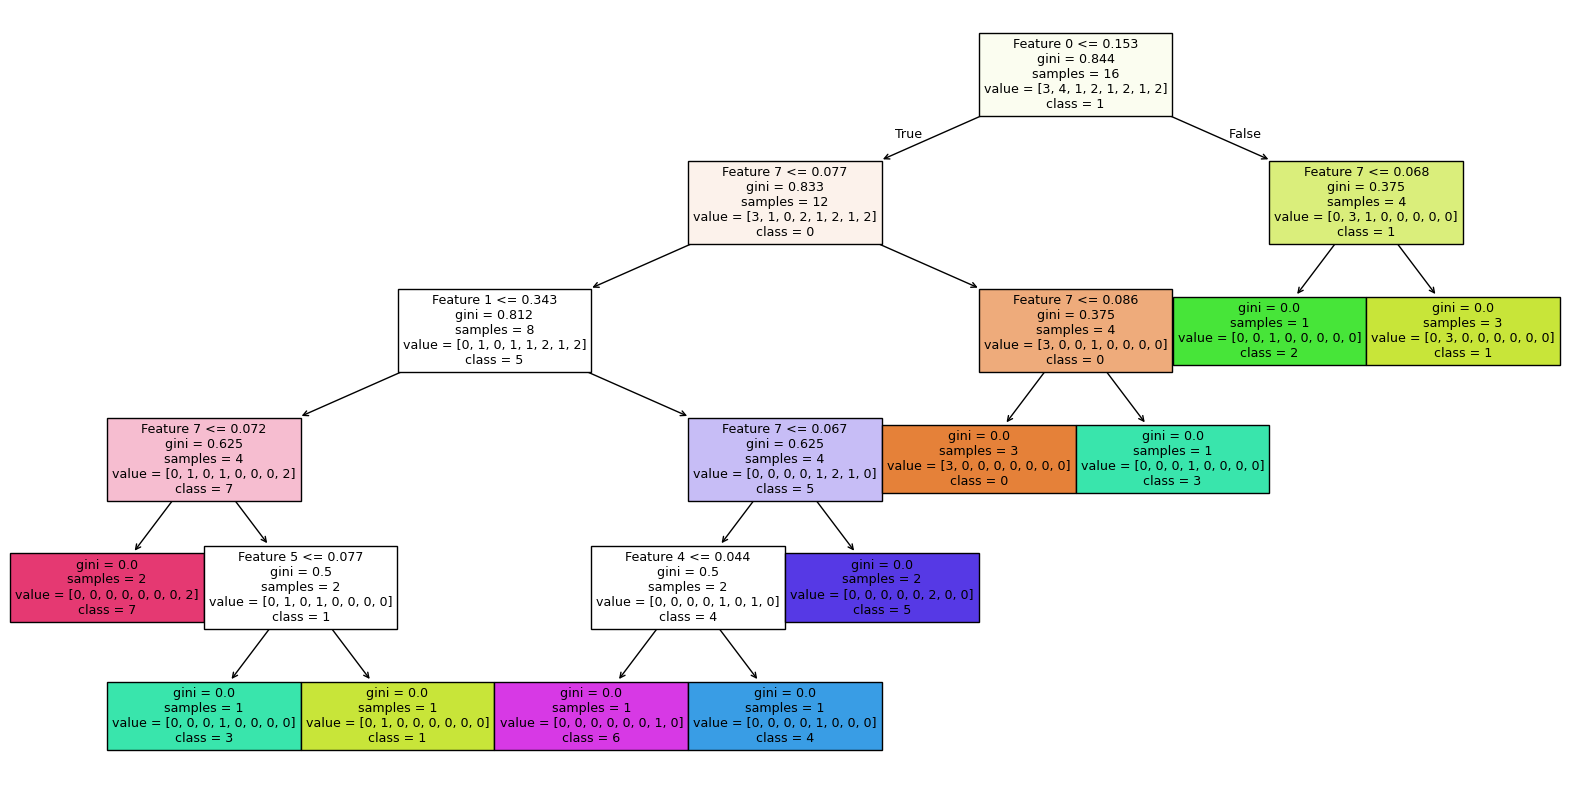

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(surrogate_model, filled=True, feature_names=[f"Feature {i}" for i in range(train_features_flat.shape[1])], class_names=[str(i) for i in range(train_labels.shape[1])])
plt.show()
